In [1]:
!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 65.3 MB/s eta 0:00:00


In [1]:
# Import modules
import string
import time
import argparse as ap
import sys
import os
import glob

import numpy as np
import pandas as pd
import obspy.core as oc
from obspy.signal.trigger import trigger_onset
from obspy.core.utcdatetime import UTCDateTime

import matplotlib.pyplot as plt

import math # for pi, sqrt, etc

import tensorflow as tf # version 2
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import losses

import h5py
import json

import random

import scipy.stats as stats
import scipy.signal as signal

from datetime import datetime

In [2]:
# Define function to produce sliding windows of signal (from original GPD GitHub repo https://github.com/interseismic/generalized-phase-detection/blob/master/gpd_predict.py)

def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

In [3]:
!git clone https://github.com/tesfahiwet-yemane/U-GPD.git

Cloning into 'U-GPD'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 206 (delta 38), reused 0 (delta 0), pack-reused 140
Receiving objects: 100% (206/206), 11.79 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [4]:
# Load model and weights
model = load_model('./U-GPD/model/best/ugpd_tf2', compile=False)
print("*** U-GPD MODEL AND WEIGHTS LOADED FROM DISK ***")

*** U-GPD MODEL AND WEIGHTS LOADED FROM DISK ***


In [5]:
# #### UNCOMMENT THIS CELL TO DOWNLOAD NABRO DATA FROM IRIS ####

# # Give start and end time to extract data
# station = "NAB*"
# day = "2011-09-26"
# starttime = UTCDateTime(day + "T00:00:00")
# endtime = UTCDateTime(day + "T23:59:59.999999")

# # Get waveforms for network 4H on this day and save as mseed (seems to be a little quicker than using the obspy client to request data)
# before = datetime.now()
# os.system("wget -O nabro_2011-247.mseed http://service.iris.edu/fdsnws/dataselect/1/query?net=4H\&sta=" + station + "\&loc=*\&cha=HH?\&start=" + str(starttime)[0:-1] + "\&end=" + str(endtime)[0:-1])
# after = datetime.now()
# print(after-before)

In [6]:
#### ALTERNATIVELY, THIS CELL DOWNLOADS DATA DIRECTLY FROM ACHIVED ZENODO REPOSITORY ####

# This file file is approx 640 MB so takes a few minutes to download...
before = datetime.now()
os.system("wget -O fdsnws-dataselect_2023-02-25t10_50_24z.mseed https://sandbox.zenodo.org/record/1167927/files/fdsnws-dataselect_2023-02-25t10_50_24z.mseed?download=1 --show-progress")
after = datetime.now()
print(after-before)

0:10:05.511580


In [7]:

#### UNCOMMENT THIS CELL IF DOWNLOADED NABRO DATA USING ABOVE ####
import glob
files = glob.glob("./fdsnws-dataselect_2023-02-25t10_50_24z.mseed") # List files

In [8]:
# Load waveforms into obspy
st = oc.Stream()
for f in np.arange(0, len(files)):
    st += oc.read(files[f])
st.sort()
#st.detrend()
#st.detrend('demean')
#st.filter('bandpass', freqmin=2, freqmax=15, corners=4, zerophase=True)
st.merge(method=0, fill_value=0)
            
stations = list(set([st[s].stats.station for s in np.arange(0, len(st))]))

In [9]:
print(st)

33 Trace(s) in Stream:

XM.A01E..HHE | 2013-12-20T00:00:00.000000Z - 2013-12-20T23:59:59.000000Z | 100.0 Hz, 8639901 samples
...
(31 other traces)
...
XM.A14E..HHZ | 2013-12-20T00:00:00.000000Z - 2013-12-20T23:59:59.000000Z | 100.0 Hz, 8639901 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


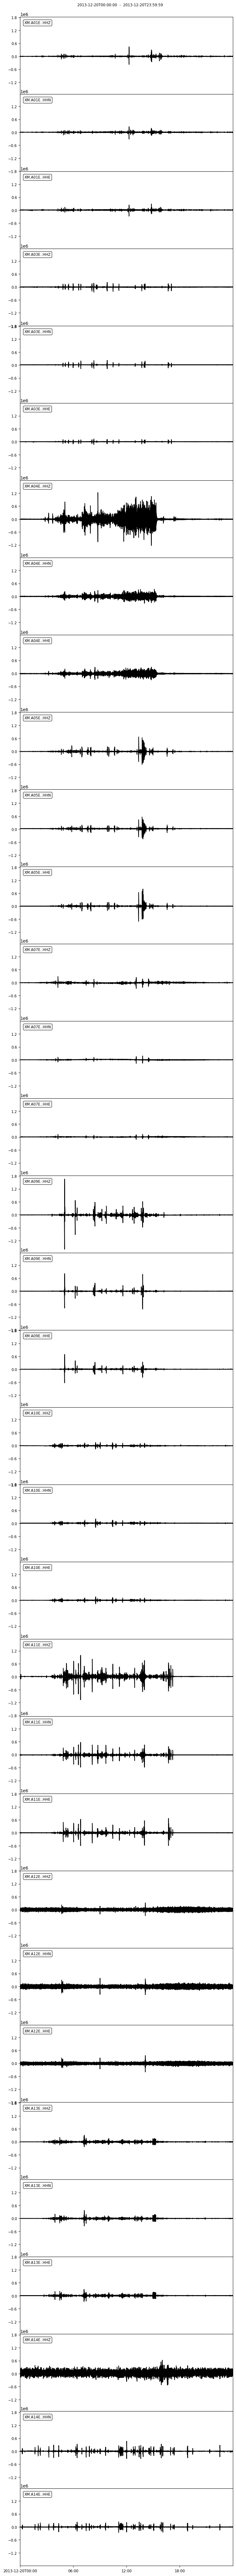

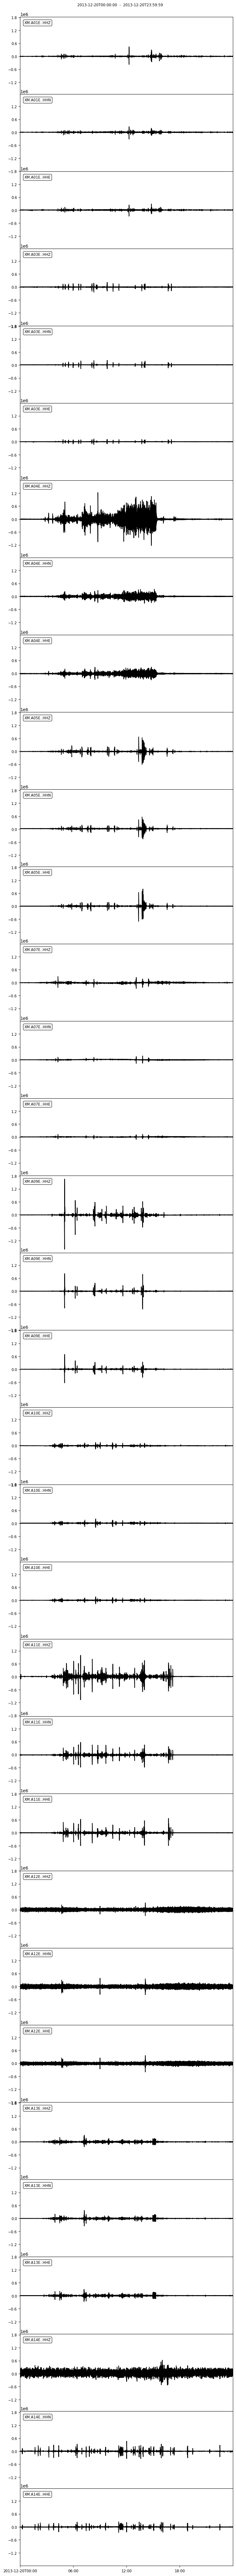

In [10]:
st.plot()

In [11]:
# Model prediction parameters
shift_size = 200 # Overlap (in samples) for sliding window
batch_size = 100 # No. of windows to process at a time

# Trigger parameters
p_thresh = 0.4 # Trigger on threshold for P-waves
s_thresh = 0.4 # Trigger on threshold for S-waves
trig_off = 0.2 # Trigerr off threshold for both phase arrivals

In [12]:
# List available stations
stations = list(set([st[s].stats.station for s in np.arange(0, len(st))]))

# Dataframe to store picks from trigger
df = pd.DataFrame(columns=['time', 'sta', 'pha', 'prob'])

# Empty obspy stream to store prediction traces
st_pred = oc.Stream()

# Loop through list of available stations
before = datetime.now() # Get time before and after to see how long this takes
for s in np.arange(0, len(stations)):

    st2 = st.select(station=stations[s])
    
    # If there are data gaps (i.e., more than 3 traces per station) then merge the traces together
    no_of_traces_per_station = st2.count() / 3
    
    if no_of_traces_per_station > 1:
        st2.merge(method=0, fill_value=0)
    
    # Trim to same length:
    latest_start = np.max([x.stats.starttime for x in st2])
    earliest_stop = np.min([x.stats.endtime for x in st2])
    st2.trim(latest_start, earliest_stop)        
    
    # Expand overlapping windows using sliding_window function
    sliding_E = sliding_window(st2[0].data, 400, stepsize=shift_size) # Slide window across first component
    tr_win = np.zeros((sliding_E.shape[0], 400, 3)) # 3D array (of zeros)
    tr_win[:,:,0] = sliding_E # Add to 3D array
    sliding_E = None # clear some memory
    
    sliding_N = sliding_window(st2[1].data, 400, stepsize=shift_size) # Slide window across second component
    tr_win[:,:,1] = sliding_N # Add to 3D array
    sliding_N = None # clear some memory
    
    sliding_Z = sliding_window(st2[2].data, 400, stepsize=shift_size) # Slide window across third component
    tr_win[:,:,2] = sliding_Z # Add to 3D array
    sliding_Z = None # clear some memory
    
    tr_win = signal.detrend(tr_win, axis=1) # Detrend 
    tr_win = tr_win / np.max(np.abs(tr_win), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)
    
    # Model prediction step...
    ts = model.predict(tr_win, verbose=True, batch_size=batch_size)
    
    # Merge overlapping predictions:
    n_steps_per_win = 400/shift_size # No. of steps per window (i.e. how many overlapping windows)
    class_trace = np.zeros((len(st2[0].data), int(3))) # Create prediction traces to be same size as input data
    for i in np.arange(0, ts.shape[0]): # For each window
        class_trace[((i * shift_size) + 100):((i * shift_size) + 300), :] += ts[i, 100:300, :] # Keep middle 200 predictions
    
    # Create obspy stream for P-pick prediction trace
    p_trace = oc.Trace()
    p_stream = oc.Stream()
    p_stream += p_trace
    p_stream[0].data = class_trace[:,0]
    p_stream[0].stats = st2[0].stats
    p_stream[0].stats.channel = "P"

    # Create obspy stream for S-pick prediction trace
    s_trace = oc.Trace()
    s_stream = oc.Stream()
    s_stream += s_trace
    s_stream[0].data = class_trace[:,1]
    s_stream[0].stats = st2[1].stats
    s_stream[0].stats.channel = "S"

    # Add them to st_pred obspy stream
    st_pred += p_stream
    st_pred += s_stream

    # Use obspy trigger to find predictions above threshold (i.e. p_thresh and s_thresh)
    # P-wave picks (trigger):
    trigs = trigger_onset(class_trace[:,0], p_thresh, trig_off) # Look for triggers (prediction trace exceeding p_thresh)
    p_picks = []
    p_probs = []
    for trig in trigs:
        if trig[1] == trig[0]:
            continue # If trigger on and off times are the same then ignore
        pick = np.argmax(class_trace[trig[0]:trig[1], 0]) + trig[0] # Use argmax between trigger on and off times as pick time
        stamp_pick = st2[0].stats.starttime + (pick * st2[0].stats.delta) # Pick time as UTCDateTime
        p_picks.append(stamp_pick) # Append time to list of P pick times
        p_probs.append(class_trace[pick, 0]) # Append prob to list of P pick probabilities
    # Add picks to df for this day            
    if len(p_picks) > 0:
        df_add = pd.DataFrame(p_picks, columns=['time'])
        df_add['sta'] = stations[s]
        df_add['pha'] = 'p'
        df_add['prob'] = p_probs
        df = pd.concat([df, df_add])
        
    # Repeat above for S-wave picks and s_thresh:
    trigs = trigger_onset(class_trace[:,1], s_thresh, trig_off)
    s_picks = []
    s_probs = []
    for trig in trigs:
        if trig[1] == trig[0]:
            continue
        pick = np.argmax(class_trace[trig[0]:trig[1], 1]) + trig[0]
        stamp_pick = st2[0].stats.starttime + (pick * st2[0].stats.delta)
        s_picks.append(stamp_pick)
        s_probs.append(class_trace[pick, 1])
    # Add picks to df for this day
    if len(s_picks) > 0:
        df_add = pd.DataFrame(s_picks, columns=['time'])
        df_add['sta'] = stations[s]
        df_add['pha'] = 's'
        df_add['prob'] = s_probs
        df = pd.concat([df, df_add])

df = df.sort_values(by='time').reset_index(drop=True) # Sort df by pick times
#df.to_pickle("trigs.pkl") # Write df to pkl file - uncomment if you want to save your model picks

after = datetime.now()
time_taken = after-before
print("24 hours data from " + str(len(stations)) + " stations processed in " + str(time_taken.seconds) + "." + str(time_taken.microseconds) + " seconds.")    



432/432 [==============================] - 3s 6ms/step
24 hours data from 11 stations processed in 127.243334 seconds.


In [13]:

st_pred

22 Trace(s) in Stream:

XM.A13E..P | 2013-12-20T00:00:00.000000Z - 2013-12-20T23:59:59.000000Z | 100.0 Hz, 8639901 samples
...
(20 other traces)
...
XM.A09E..S | 2013-12-20T00:00:00.000000Z - 2013-12-20T23:59:59.000000Z | 100.0 Hz, 8639901 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

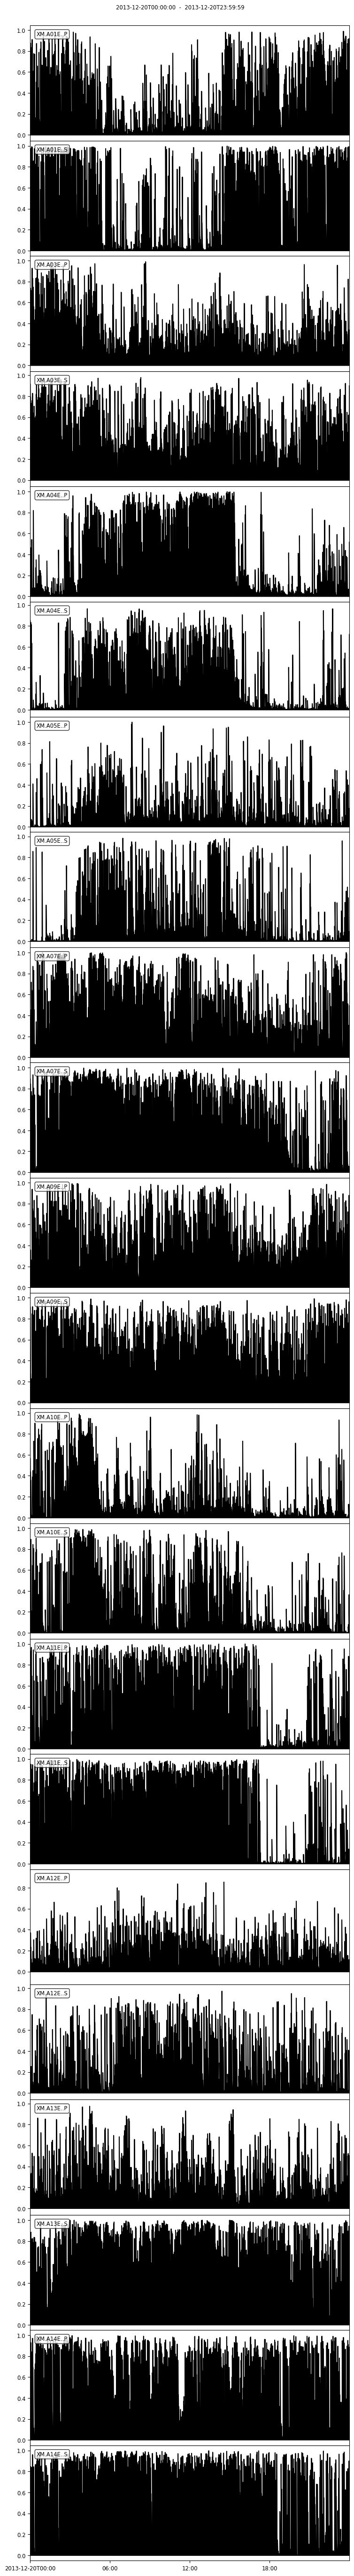

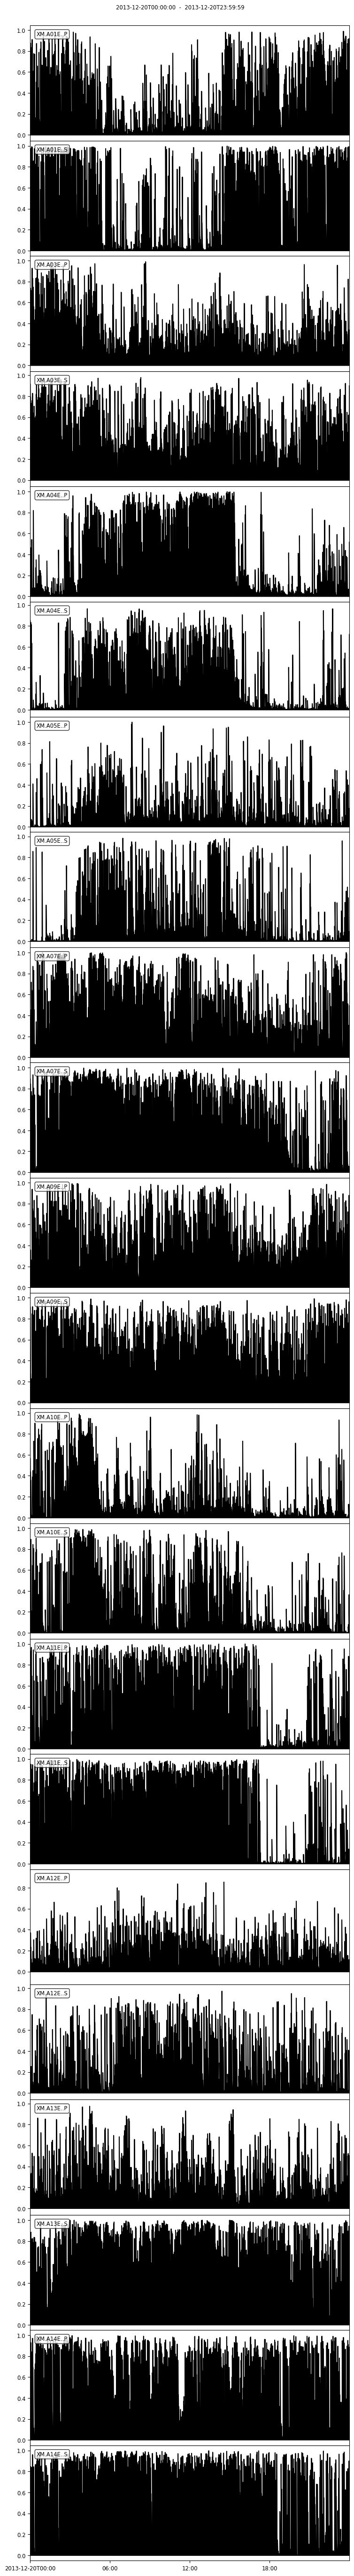

In [14]:
# Plot of machine learning prediction traces for each station
st_pred.plot()

In [15]:
# Machine learning picks (when above predictions exceed threshold of 0.4)
df

time   sta pha      prob
0      2013-12-20T00:00:02.570000Z  A13E   s  0.734235
1      2013-12-20T00:00:05.430000Z  A13E   s  0.592012
2      2013-12-20T00:00:21.340000Z  A14E   p  0.993902
3      2013-12-20T00:00:22.350000Z  A03E   s  0.918860
4      2013-12-20T00:00:23.810000Z  A14E   p  0.821966
...                            ...   ...  ..       ...
36574  2013-12-20T23:59:28.000000Z  A03E   s  0.418818
36575  2013-12-20T23:59:34.230000Z  A07E   p  0.492670
36576  2013-12-20T23:59:38.060000Z  A13E   s  0.629680
36577  2013-12-20T23:59:52.980000Z  A09E   p  0.567930
36578  2013-12-20T23:59:53.110000Z  A09E   s  0.697469

[36579 rows x 4 columns]

In [16]:
# By station
for s in list(set(df['sta'])):
    no_p_picks = df.loc[(df['sta'] == s) & (df['pha'] == "p")].shape[0]
    no_s_picks = df.loc[(df['sta'] == s) & (df['pha'] == "s")].shape[0]
    print("Station " + s + ": " + str(no_p_picks) + " P-waves and " + str(no_s_picks) + " S-waves.")

Station A13E: 454 P-waves and 5770 S-waves.
Station A14E: 2645 P-waves and 2906 S-waves.
Station A07E: 1592 P-waves and 3239 S-waves.
Station A10E: 386 P-waves and 917 S-waves.
Station A12E: 135 P-waves and 406 S-waves.
Station A01E: 1018 P-waves and 1595 S-waves.
Station A11E: 2874 P-waves and 3533 S-waves.
Station A04E: 2864 P-waves and 665 S-waves.
Station A03E: 587 P-waves and 999 S-waves.
Station A05E: 250 P-waves and 686 S-waves.
Station A09E: 1384 P-waves and 1674 S-waves.


In [17]:
df_p = df.loc[df['pha'] == "p"] # Extract just P-wave picks
df_p.reset_index(drop=True, inplace=True) # Reset dataframe indexing

pick_groups = [] # Create empty list to store P-wave groupings

# First loop through each pick finding all picks within 4 seconds of that pick - this takes around 20 secs
for i in range(df_p.shape[0]):
    this_time = df_p['time'][i]
    this_bin = df_p.loc[(df_p['time'] >= this_time) & (df_p['time'] <= (this_time + 4))]
    
    # If 4+ stations then add to pick_groups list
    if this_bin.shape[0] >= 4:
        if len(list(set(this_bin['sta']))) >= 4:
            pick_groups.append(this_bin)

# Remove groups that are fully contained in another
# First 'backwards' (remove groups that are fully contained in the previous group)
for i in reversed(range(len(pick_groups))):
    if i == 0:
        continue
    else:
        if pick_groups[i].isin(pick_groups[(i-1)]).all().all():
            del(pick_groups[i])
# Then 'forwards' (remove groups that are fully contained in the next group)
for i in reversed(range(len(pick_groups)-1)):
    if pick_groups[i].isin(pick_groups[(i+1)]).all().all():
        del(pick_groups[i])

print("Total no. of P-wave groups = " + str(len(pick_groups)))

Total no. of P-wave groups = 132


In [18]:
pick_groups

[                            time   sta pha      prob
 565  2013-12-20T01:30:59.050000Z  A03E   p  0.781092
 566  2013-12-20T01:31:00.510000Z  A07E   p  0.536078
 567  2013-12-20T01:31:00.980000Z  A14E   p  0.853563
 568  2013-12-20T01:31:02.880000Z  A09E   p  0.575665,
                             time   sta pha      prob
 566  2013-12-20T01:31:00.510000Z  A07E   p  0.536078
 567  2013-12-20T01:31:00.980000Z  A14E   p  0.853563
 568  2013-12-20T01:31:02.880000Z  A09E   p  0.575665
 569  2013-12-20T01:31:03.530000Z  A03E   p  0.791869,
                             time   sta pha      prob
 888  2013-12-20T02:07:37.680000Z  A07E   p  0.885275
 889  2013-12-20T02:07:37.720000Z  A13E   p  0.409351
 890  2013-12-20T02:07:39.340000Z  A10E   p  0.608014
 891  2013-12-20T02:07:41.600000Z  A09E   p  0.928359,
                              time   sta pha      prob
 1169  2013-12-20T02:38:16.770000Z  A03E   p  0.523925
 1170  2013-12-20T02:38:16.980000Z  A14E   p  0.463687
 1171  2013-12-20T02:3

In [19]:
# Check for any groups that have more than 1 pick - first increase threshold for all picks then use phase w/ highest prob
for i in reversed(range(len(pick_groups))):
    if pick_groups[i]['sta'].duplicated().any(): # If more than one pick for any station
        pick_groups[i] = pick_groups[i].loc[pick_groups[i]['prob'] >= 0.6] # First only keep picks above higher threshold (0.6)

        if len(list(set(pick_groups[i]['sta']))) < 4:
            del(pick_groups[i]) # Remove group if increased threshold reduces number of stations to less than 4
        else:
            # Otherwise check if any stations still have more than one pick and keep only highest probability pick
            if pick_groups[i]['sta'].duplicated().any():
                pick_groups[i] = pick_groups[i].sort_values('prob').drop_duplicates('sta', keep='last')

print("No. of P-wave groups after increasing threshold for groups with multiple picks per station and reducing no. of picks to one per station = " + str(len(pick_groups)))

# Then check for overlapping groups and choose group with highest mean probability
for i in reversed(range(len(pick_groups)-1)):
    if pick_groups[i].index.isin(pick_groups[i+1].index).any():
        if np.mean(pick_groups[i]['prob']) >= np.mean(pick_groups[i+1]['prob']):
            del(pick_groups[i+1])
        else:
            del(pick_groups[i])

print("No. of P-wave groups after removing overlapping groups = " + str(len(pick_groups)))

No. of P-wave groups after increasing threshold for groups with multiple picks per station and reducing no. of picks to one per station = 68
No. of P-wave groups after removing overlapping groups = 60


In [20]:
# Make directories to store NLL pickfile, velocity model, travel time grid and locations
!mkdir ./NLL
!mkdir ./NLL/picks
!mkdir ./NLL/model
!mkdir ./NLL/time
!mkdir ./NLL/loc

In [21]:
# Loop through groups of picks, producing strings to go in NonLinLoc phase input file (e.g., http://alomax.free.fr/nlloc/soft7.00/formats.html#_phase_nlloc_)
# And then write strings to NLL phase input file

phase_file_str = [] # List to store strings for NLL phase input file

# Loop through groups and picks producing appropriate strings for phase input file
for i in range(len(pick_groups)):
    pick_groups[i].reset_index(drop=True, inplace=True) # Reset indices for each dataframe for looping through
    for j in range(pick_groups[i].shape[0]):
        if (i > 0) and (j == 0):
            phase_file_str.append(" ") # Add a blank line after each event
        this_line = pick_groups[i]['sta'][j].ljust(7) # Station
        this_line += '?'.ljust(5) # Instrument (leave as ?)
        this_line += "?".ljust(5) # Component (leave as ?)
        this_line += "? P".ljust(9) # Onset (leave as ? as don't know if impulsive or emergent) and phase descriptor (P)
        this_line += "? " # First motion (i.e. compression/dilation, leave as ? as don't know)
        this_line += str(pick_groups[i]['time'][j].year) # Year
        this_line += str(pick_groups[i]['time'][j].month).zfill(2) # Month (2 digits)
        this_line += str(pick_groups[i]['time'][j].day).zfill(2) # Day (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].hour).zfill(2) # Hour (2 digits)
        this_line += str(pick_groups[i]['time'][j].minute).zfill(2) # Minute (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].second).zfill(2) # Second (2 digits)
        this_line += "." + str(pick_groups[i]['time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
        this_line += " GAU " # Error type = Gaussian
        if pick_groups[i]['prob'][j] >= 0.85:
            this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
        elif pick_groups[i]['prob'][j] >= 0.7:
            this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
        elif pick_groups[i]['prob'][j] >= 0.55:
            this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
        else:
            this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
        this_line += "-1.00e+00 " # Coda duration (negative = don't use)
        this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
        this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

        phase_file_str.append(this_line) # Append line to list

# Write phase input file
with open('./NLL/picks/pickfile.hpf', 'w') as f:
    for item in phase_file_str:
        f.write("%s\n" % item)


In [22]:
!wget http://alomax.free.fr/nlloc/soft7.00/tar/NLL7.00_src.tgz; tar -zxf NLL7.00_src.tgz; cd src; make distrib

--2023-03-13 09:24:05--  http://alomax.free.fr/nlloc/soft7.00/tar/NLL7.00_src.tgz
Resolving alomax.free.fr (alomax.free.fr)... 212.27.63.116
Connecting to alomax.free.fr (alomax.free.fr)|212.27.63.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407847 (398K) [application/x-gzip]
Saving to: ‘NLL7.00_src.tgz’

NLL7.00_src.tgz     100%[===================>] 398.29K   150KB/s    in 2.7s    

2023-03-13 09:24:09 (150 KB/s) - ‘NLL7.00_src.tgz’ saved [407847/407847]

gcc -c -O3 -Wall -std=gnu99  NLLoc_main.c  
gcc -c -O3 -Wall -std=gnu99  NLLoc1.c  
NLLoc1.c: In function ‘NLLoc’:
NLLoc1.c:277:9: warning: ignoring return value of ‘system’, declared with attribute warn_unused_result [-Wunused-result]
  277 |         system(sys_command);
      |         ^~~~~~~~~~~~~~~~~~~
NLLoc1.c:280:9: warning: ignoring return value of ‘system’, declared with attribute warn_unused_result [-Wunused-result]
  280 |         system(sys_command);
      |         ^~~~~~~~~~~~~~~~~~~
NLL

In [23]:
!./src/Vel2Grid ./U-GPD/NLL/NLL_master.in
!./src/Grid2Time ./U-GPD/NLL/NLL_master.in

Streaming output truncated to the last 5000 lines.
z_side 60->61: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 147->148: ff fb bb bf 
y_side 139->140: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 18->17: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 140->141: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 17->16: ff fb bb bf 
x_side 149->150: ff fb bb bf 
y_side 141->142: ff fb bb bf 
z_side 63->64: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 16->15: ff fb bb bf 
x_side 150->151: ff fb bb bf 
y_side 142->143: ff fb bb bf 
z_side 64->65: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 15->14: ff fb bb bf 
x_side 151->152: ff fb bb bf 
y_side 143->144: ff fb bb bf 
z_side 65->66: ff fb bb bf 
x_side 22->21: ff fb bb bf 
y_side 14->13: ff fb bb bf 
x_side 152->153: ff fb bb bf 
y_side 144->145: ff fb bb bf 
z_side 66->67: ff fb bb bf 
x_side 21->20: ff fb bb bf 
y_side 13->12: ff fb bb bf 
x

In [24]:
!./src/NLLoc ./U-GPD/NLL/NLL_master.in

Finished event location, output files: ./NLL/loc/ALL.20131220.013100.* <./NLL/loc/ALL.20131220.013100.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20131220.020737.* <./NLL/loc/ALL.20131220.020737.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20131220.023816.* <./NLL/loc/ALL.20131220.023816.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20131220.034142.* <./NLL/loc/ALL.20131220.034142.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20131220.042726.* <./NLL/loc/ALL.20131220.042726.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20131220.042736.* <./NLL/loc/ALL.20131220.042736.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20131220.043211.* <./NLL/loc/ALL.20131220.043211.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20131220.043651.* <./NLL/loc/ALL.20131220.043651.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20131220.04

In [25]:
# Read in origin times from NLL location summary file:
with open("./NLL/loc/ALL.sum.grid0.loc.hyp","r") as fi:
    origins = []
    for ln in fi:
        if ln.startswith("GEOGRAPHIC"):
            origins.append(ln[15:42]) # Take origin time info from GEOGRAPHIC line in summary hyp file

# Loop through and convert origin times to UTCDateTime
for i in range(len(origins)):
    origins[i] = UTCDateTime(origins[i][:4] + origins[i][5:7] + origins[i][8:10] + "T" + origins[i][12:14] + origins[i][15:17] + ("%.4f" % float(origins[i][18:27])).zfill(7))

# Get dataframe of model S-wave picks
df_s = df.loc[df['pha'] == "s"] # Extract just S-wave picks
df_s.reset_index(drop=True, inplace=True) # Reset dataframe indexing

# Then loop through P-wave pick groups finding any S-waves to add:
for i in range(len(pick_groups)):
    # Add columns for new S-wave times and probabilities:
    pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
    pick_groups[i]['s_prob'] = 0. # Put zero probability initially
    # Loop through picks in each group
    for j in range(pick_groups[i].shape[0]):
        p_origin_diff = pick_groups[i]['time'][j] - origins[i] # P arrival time minus origin time
        s_window = df_s.loc[(df_s['time'] >= origins[i] + (p_origin_diff * 1.76 * 0.67)) & (df_s['time'] <= origins[i] + (p_origin_diff * 1.76 * 1.5))] # Any picks within predicted S arrival window?
        s_window = s_window.loc[s_window['sta'] == pick_groups[i]['sta'][j]] # Any S picks within window and from this station?
        # If so...
        if s_window.shape[0] > 0:
            if s_window.shape[0] > 1:
                # If more than one pick for this station, use pick with highest probability
                s_window = s_window.sort_values('prob').drop_duplicates('sta', keep='last')
            s_window.reset_index(inplace=True, drop=True) # Reset index
            # Add pick to pick_groups dataframe
            pick_groups[i]['s_time'][j] = s_window['time'][0]
            pick_groups[i]['s_prob'][j] = s_window['prob'][0]

<ipython-input-25-6d675102c263>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
<ipython-input-25-6d675102c263>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
<ipython-input-25-6d675102c263>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [26]:
# A quick look at our new groupings
pick_groups

[                          time   sta pha      prob  \
 0  2013-12-20T01:31:00.510000Z  A07E   p  0.536078   
 1  2013-12-20T01:31:00.980000Z  A14E   p  0.853563   
 2  2013-12-20T01:31:02.880000Z  A09E   p  0.575665   
 3  2013-12-20T01:31:03.530000Z  A03E   p  0.791869   
 
                         s_time  s_prob  
 0  2013-12-20T01:31:00.510000Z     0.0  
 1  2013-12-20T01:31:00.980000Z     0.0  
 2  2013-12-20T01:31:02.880000Z     0.0  
 3  2013-12-20T01:31:03.530000Z     0.0  ,
                           time   sta pha      prob  \
 0  2013-12-20T02:07:37.680000Z  A07E   p  0.885275   
 1  2013-12-20T02:07:37.720000Z  A13E   p  0.409351   
 2  2013-12-20T02:07:39.340000Z  A10E   p  0.608014   
 3  2013-12-20T02:07:41.600000Z  A09E   p  0.928359   
 
                         s_time  s_prob  
 0  2013-12-20T02:07:37.680000Z     0.0  
 1  2013-12-20T02:07:37.720000Z     0.0  
 2  2013-12-20T02:07:39.340000Z     0.0  
 3  2013-12-20T02:07:41.600000Z     0.0  ,
                        

In [27]:
# Rewrite NLL phase input file:

phase_file_str = [] # Empty list to store strings for NLL phase input file

# Loop through groups and picks producing appropriate strings for phase input file
for i in range(len(pick_groups)):
    pick_groups[i].reset_index(drop=True, inplace=True) # Reset indices for each dataframe for looping through
    for j in range(pick_groups[i].shape[0]):
        if (i > 0) and (j == 0):
            phase_file_str.append(" ") # Add a blank line after each event
        this_line = pick_groups[i]['sta'][j].ljust(7) # Station
        this_line += '?'.ljust(5) # Instrument (leave as ?)
        this_line += "?".ljust(5) # Component (leave as ?)
        this_line += "? P".ljust(9) # Onset (leave as ? as don't know if impulsive or emergent) and phase descriptor (P)
        this_line += "? " # First motion (i.e. compression/dilation, leave as ? as don't know)
        this_line += str(pick_groups[i]['time'][j].year) # Year
        this_line += str(pick_groups[i]['time'][j].month).zfill(2) # Month (2 digits)
        this_line += str(pick_groups[i]['time'][j].day).zfill(2) # Day (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].hour).zfill(2) # Hour (2 digits)
        this_line += str(pick_groups[i]['time'][j].minute).zfill(2) # Minute (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].second).zfill(2) # Second (2 digits)
        this_line += "." + str(pick_groups[i]['time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
        this_line += " GAU " # Error type = Gaussian
        if pick_groups[i]['prob'][j] >= 0.85:
            this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
        elif pick_groups[i]['prob'][j] >= 0.7:
            this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
        elif pick_groups[i]['prob'][j] >= 0.55:
            this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
        else:
            this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
        this_line += "-1.00e+00 " # Coda duration (negative = don't use)
        this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
        this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

        phase_file_str.append(this_line) # Append line to list

        # Check if there is an associated S-wave pick for this station and append to the phase file:
        if pick_groups[i]['s_prob'][j] >= 0.4:
            this_line = pick_groups[i]['sta'][j].ljust(7) # Station
            this_line += '?'.ljust(5) # Instrument (leave as ?)
            this_line += "?".ljust(5) # Component (leave as ?)
            this_line += "? S".ljust(9) # Onset (leave as ? as now S-wave) and phase descriptor (S)
            this_line += "? " # First motion (i.e. compression/dilation, leave as ? as now S-wave)
            this_line += str(pick_groups[i]['s_time'][j].year) # Year
            this_line += str(pick_groups[i]['s_time'][j].month).zfill(2) # Month (2 digits)
            this_line += str(pick_groups[i]['s_time'][j].day).zfill(2) # Day (2 digits)
            this_line += " " + str(pick_groups[i]['s_time'][j].hour).zfill(2) # Hour (2 digits)
            this_line += str(pick_groups[i]['s_time'][j].minute).zfill(2) # Minute (2 digits)
            this_line += " " + str(pick_groups[i]['s_time'][j].second).zfill(2) # Second (2 digits)
            this_line += "." + str(pick_groups[i]['s_time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
            this_line += " GAU " # Error type = Gaussian
            # Keep same error magnitudes as P-wave arrivals
            if pick_groups[i]['prob'][j] >= 0.85:
                this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
            elif pick_groups[i]['prob'][j] >= 0.7:
                this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
            elif pick_groups[i]['prob'][j] >= 0.55:
                this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
            else:
                this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
            this_line += "-1.00e+00 " # Coda duration (negative = don't use)
            this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
            this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

            phase_file_str.append(this_line) # Append line to list

# Write new phase file
with open('./NLL/picks/pickfile_s.hpf', 'w') as f:
    for item in phase_file_str:
        f.write("%s\n" % item)

In [31]:
# Make new directory for locating events with S-waves included:
!mkdir ./NLL/loc_s

In [32]:
#### UNCOMMENT THESE LINES IF USING DEFINED S-WAVE VELOCITY (i.e., not using constant Vp/Vs ratio) ####

# Create velocity and travel-time grids for S-wave velocity model
!./src/Vel2Grid ./U-GPD/NLL/NLL_master_s.in
!./src/Grid2Time ./U-GPD/NLL/NLL_master_s.in

# Run NonLinLoc again (using pre-made Control File for including S-waves)
!./src/NLLoc ./U-GPD/NLL/NLL_master_s.in

Streaming output truncated to the last 5000 lines.
x_side 15->14: ff fb bb bf 
y_side 7->6: ff fb bb bf 
x_side 159->160: ff fb bb bf 
y_side 151->152: ff fb bb bf 
z_side 73->74: ff fb bb bf 
x_side 14->13: ff fb bb bf 
y_side 6->5: ff fb bb bf 
y_side 152->153: ff fb bb bf 
z_side 74->75: ff fb bb bf 
x_side 13->12: ff fb bb bf 
y_side 5->4: ff fb bb bf 
y_side 153->154: ff fb bb bf 
z_side 75->76: ff fb bb bf 
x_side 12->11: ff fb bb bf 
y_side 4->3: ff fb bb bf 
y_side 154->155: ff fb bb bf 
z_side 76->77: ff fb bb bf 
x_side 11->10: ff fb bb bf 
y_side 3->2: ff fb bb bf 
y_side 155->156: ff fb bb bf 
z_side 77->78: ff fb bb bf 
x_side 10->9: ff fb bb bf 
y_side 2->1: ff fb bb bf 
y_side 156->157: ff fb bb bf 
z_side 78->79: ff fb bb bf 
x_side 9->8: ff fb bb bf 
y_side 1->0: ff fb bb bf 
y_side 157->158: ff fb bb bf 
z_side 79->80: ff fb bb bf 
x_side 8->7: ff fb bb bf 
y_side 158->159: ff fb bb bf 
z_side 80->81: ff fb bb bf 
x_side 7->6: ff fb bb bf 
y_side 159->160: ff fb bb bf

In [29]:
#### LEAVE THESE LINES UNCOMMENTED IF USING CONSTANT Vp/Vs ####
# Run NonLinLoc again (using pre-made Control File for including S-waves)
#!./src/NLLoc ./U-GPD/NLL/NLL_master_s_constantVpVs.in

In [33]:
origins = []
lats = []
lons = []
depths = []

with open("./NLL/loc_s/ALL.sum.grid0.loc.hyp","r") as fi:
    for ln in fi:
        if ln.startswith("GEOGRAPHIC"):
            origins.append(ln[15:42])
            lats.append(float(ln[48:56]))
            lons.append(float(ln[62:71]))
            depths.append(float(ln[78:]))

# # Loop through and convert origin times to UTCDateTime
for i in range(len(origins)):
    origins[i] = UTCDateTime(origins[i][:4] + origins[i][5:7] + origins[i][8:10] + "T" + origins[i][12:14] + origins[i][15:17] + ("%.4f" % float(origins[i][18:27])).zfill(7))

# Create dataframe of event locations
df_events = pd.DataFrame(list(zip(origins, lats, lons, depths)), 
               columns =['time', 'lat', 'lon', 'depth'])

In [42]:
# Quick look at events dataframe
#from google.colab import data_table
#df_events.table.enable_dataframe_formatter()
df_events

time       lat        lon      depth
0   2013-12-20T01:30:59.391300Z  7.662286  38.776027  -2.052083
1   2013-12-20T02:07:36.877200Z  7.721214  38.753375  -0.484375
2   2013-12-20T02:38:15.956500Z  7.834786  38.779430  -2.276042
3   2013-12-20T03:41:43.868000Z  7.896393  38.800581  -1.492187
4   2013-12-20T04:27:24.380200Z  7.890500  38.777319  -2.276042
5   2013-12-20T04:27:34.812000Z  7.800500  38.865913  -0.036458
6   2013-12-20T04:32:11.502100Z  7.795946  38.790479  -2.444010
7   2013-12-20T04:36:50.805400Z  7.689071  38.764159  -1.380208
8   2013-12-20T04:37:57.171300Z  7.859964  38.852461   2.539062
9   2013-12-20T04:39:33.723900Z  7.851929  38.729694  -2.276042
10  2013-12-20T04:39:37.082500Z  7.805857  38.497145   0.187500
11  2013-12-20T04:40:39.103900Z  7.928000  38.694059   1.531250
12  2013-12-20T04:41:43.136700Z  7.833179  38.810252  -1.492187
13  2013-12-20T04:46:06.072600Z  0.733536   8.803664   1.492187
14  2013-12-20T04:50:46.834300Z  7.778000  38.555532   2.427083
15  2013-12-20T04:51:47.718000Z  7.728714  38.946925  10.937500
16  2013-12-20T04:58:59.618400Z  7.726036  38.737701   2.315104
17  2013-12-20T05:03:30.275300Z  7.761393  38.657712  -2.388021
18  2013-12-20T05:03:56.180400Z  7.794071  38.781555  -1.380208
19  2013-12-20T05:05:04.191300Z  0.806929   8.775078   2.276042
20  2013-12-20T05:12:21.093200Z  7.831571  38.618281  10.937500
21  2013-12-20T05:13:42.869400Z  7.794607  38.806969  -2.164062
22  2013-12-20T05:19:02.642900Z  0.778536   8.722605   1.492187
23  2013-12-20T07:04:34.952800Z  7.797554  38.775881  -1.996094
24  2013-12-20T07:14:00.438900Z  0.708357   8.746877   1.380208
25  2013-12-20T07:17:14.515600Z  7.860500  38.718885   3.098958
26  2013-12-20T07:18:17.218400Z  7.787107  38.743159  -1.492187
27  2013-12-20T07:33:08.196700Z  0.692286   8.685237   2.052083
28  2013-12-20T07:35:58.253900Z  7.748536  38.765834  -1.492187
29  2013-12-20T08:29:34.767700Z  7.765679  38.755035  -1.492187
30  2013-12-20T08:37:24.769900Z  7.788179  38.812370  -2.164062
31  2013-12-20T08:57:30.581300Z  7.821393  38.821055  -2.388021
32  2013-12-20T09:01:53.498900Z  7.703000  38.557665   5.562500
33  2013-12-20T09:05:48.452300Z  7.781214  38.723148  -1.380208
34  2013-12-20T09:06:19.057300Z  7.723357  38.762027  -0.932292
35  2013-12-20T10:38:53.322600Z  7.790054  38.771548  -1.772135
36  2013-12-20T11:05:06.641500Z  0.816036   8.739939   1.492187
37  2013-12-20T11:29:22.404300Z  7.765679  38.690155  -1.492187
38  2013-12-20T11:29:39.326400Z  7.760321  38.766925  -1.492187
39  2013-12-20T11:49:45.492200Z  7.803714  38.949188   4.218750
40  2013-12-20T11:55:51.007800Z  7.761929  38.889659  10.265625
41  2013-12-20T12:21:01.357400Z  0.746929   8.707983   0.651042
42  2013-12-20T12:21:17.919300Z  7.839607  38.733469  -0.372396
43  2013-12-20T12:24:28.832100Z  7.864786  38.837865  -2.276042
44  2013-12-20T12:36:42.829000Z  7.812821  38.749669  -1.268229
45  2013-12-20T12:53:13.804700Z  7.790857  38.806424  -2.052083
46  2013-12-20T13:10:45.874600Z  7.768357  38.803158  -1.380208
47  2013-12-20T13:28:55.141800Z  7.859964  38.705365  -0.596354
48  2013-12-20T13:29:37.330100Z  7.785500  38.729640   0.411458
49  2013-12-20T13:33:39.368400Z  7.787643  38.725316  -0.036458
50  2013-12-20T13:44:25.676100Z  7.843893  38.711842   0.523438
51  2013-12-20T14:01:03.767400Z  0.796750   8.758307   0.596354
52  2013-12-20T14:02:35.235200Z  7.812821  38.747506  -0.372396
53  2013-12-20T14:16:58.558100Z  7.783357  38.770731   0.859375
54  2013-12-20T14:23:52.424800Z  7.919429  38.620494  -0.260417
55  2013-12-20T15:01:43.915900Z  7.584071  38.746773  -2.276042
56  2013-12-20T15:15:59.306500Z  7.805321  38.692346  -0.596354
57  2013-12-20T22:39:16.515200Z  7.753357  38.746915  12.953125
58  2013-12-20T23:25:24.715400Z  7.699786  38.800928  -2.276042
59  2013-12-20T23:44:57.018400Z  7.674071  38.738199  -0.484375

In [43]:
df_events.to_excel(r'NLL\events.xlsx', index=False)

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [49]:
df_catalogue = pd.read_excel('./ARGOS_Catalog.xlsx', header=1)
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [76]:
df_events.dtypes

time      object
lat      float64
lon      float64
depth    float64
dtype: object

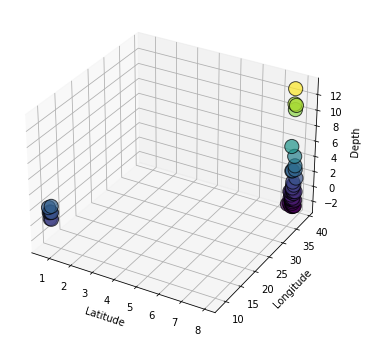

In [50]:
from mpl_toolkits.mplot3d import Axes3D

x = df_events["lat"]
y = df_events["lon"]
z = df_events["depth"]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Depth')
plt.show()

In [51]:
df_catalogue

YYYY   MM   DD   hh   mm   ss.mmmm         MLDateNum       Lat   \
0      2012    1   10    9   52   26.3817     734878.411416   7.86449   
1      2012    1   10   22    2   38.0681     734878.918496   7.81778   
2      2012    1   11    0   11   15.1495     734879.007814   7.55660   
3      2012    1   11    5    2   48.1591     734879.210280   7.65881   
4      2012    1   11    7   28    6.8849     734879.311191   7.71214   
...     ...  ...  ...  ...  ...       ...               ...       ...   
2744   2014    1   29    2    6   25.7100     735628.087798   7.86328   
2745   2014    1   29   11   32   29.4676     735628.480897   7.72827   
2746   2014    1   30   20   47   31.0735     735629.866332   6.94240   
2747   2014    1   30   22   44   54.5582     735629.947854   6.96057   
2748   2014    1   30   23    8    1.5889     735629.963907   7.13627   

          Lon      Dep    ErrEll     ErrX     ErrY    ErrZ       ML   \
0       38.8149   -1.940       738     4.34     4.23    2.96   1.525   
1       38.7872    6.452     10839     8.15    10.13    4.14   0.609   
2       38.7194    2.588    108902    19.15    19.20    9.30   1.056   
3       38.7396   -1.276     32656    13.39    15.65    5.31   1.884   
4       38.8792    2.347    405938    38.34    51.35    9.44   1.786   
...         ...      ...       ...      ...      ...     ...     ...   
2744    38.8726    8.987       556     2.30     2.54    3.55   0.777   
2745    38.8803   -1.879       514     4.29     1.35    3.22   1.559   
2746    38.4897    2.588     11907     4.59    14.65    6.20   1.723   
2747    38.3407    6.210     13295     9.31    10.27    4.70   1.856   
2748    38.4451    5.607     15644    14.27    10.66    4.92   0.707   

          MLEnRel      Wo,m\t     Fc\t  \
0     2.440000e+11   2.580e-08   17.70   
1     1.030000e+10   9.100e-10   23.02   
2     4.830000e+10   1.020e-09   14.21   
3     8.430000e+11   1.810e-09   30.00   
4     6.010000e+11   2.680e-09   28.70   
...            ...         ...     ...   
2744  1.840000e+10   3.160e-09   17.07   
2745  2.750000e+11   1.130e-08   14.95   
2746  4.840000e+11   1.600e-08   17.75   
2747  7.660000e+11   2.220e-08    7.06   
2748  1.450000e+10   4.140e-08   26.37   

        Mo,Nm\tMw Rad,km  dSig,bar   MwEnRel\tDip\tStrike     Rake        
0      8.270e+11 1.724 0.0551 4.340e+01 4.850e+11   NaN       NaN    NaN  
1      2.420e+10 0.682 0.0465 1.030e+00 1.330e+10   NaN       NaN    NaN  
2      2.830e+10 0.897 0.0672 4.090e-01 2.790e+10   NaN       NaN    NaN  
3      2.650e+10 0.879 0.0308 3.960e+00 2.620e+10   NaN       NaN    NaN  
4      2.910e+11 1.573 0.0333 3.460e+01 2.880e+11   NaN       NaN    NaN  
...                                                 ...              ...  
2744   1.190e+11 1.277 0.0753 1.480e+00 1.040e+11   NaN       NaN    NaN  
2745   4.880e+11 1.661 0.0630 1.130e+01 3.900e+11   NaN       NaN    NaN  
2746   6.580e+11 1.788 0.0758 3.120e+01 6.050e+11   NaN       NaN    NaN  
2747   2.250e+12 2.057 0.1657 1.840e+00 1.530e+12   NaN       NaN    NaN  
2748   3.010e+11 1.511 0.0492 3.030e+01 2.330e+11   NaN       NaN    NaN  

[2749 rows x 20 columns]

In [65]:
df_test = df_catalogue.iloc[2622:2627,0:10]

In [66]:
df_test

YYYY   MM   DD   hh   mm   ss.mmmm         MLDateNum       Lat   \
2622   2013   12   20    1   20   50.7539     735588.056143   7.84394   
2623   2013   12   20   21   40   45.1469     735588.903300   7.86039   
2624   2013   12   20   22   11   39.7795     735588.924766   7.79413   
2625   2013   12   20   23   19   30.6889     735588.971883   7.77987   
2626   2013   12   20   23   24   49.4841     735588.975573   7.76146   

          Lon      Dep    
2622    38.6598   -0.551  
2623    38.7191    1.622  
2624    38.8555   -1.759  
2625    38.7791   -1.759  
2626    37.9161   26.011

In [67]:
df_test.columns

Index(['YYYY ', 'MM ', 'DD ', 'hh ', 'mm ', 'ss.mmmm ', '      MLDateNum ',
       '    Lat ', '    Lon  ', '   Dep  '],
      dtype='object')

In [77]:
df_test.dtypes

YYYY                  int64
MM                    int64
DD                    int64
hh                    int64
mm                    int64
ss.mmmm             float64
      MLDateNum     float64
    Lat             float64
    Lon             float64
   Dep               object
dtype: object

In [78]:
df_test['   Dep  '] =df_test['   Dep  '].astype(float)

In [79]:
df_test.dtypes

YYYY                  int64
MM                    int64
DD                    int64
hh                    int64
mm                    int64
ss.mmmm             float64
      MLDateNum     float64
    Lat             float64
    Lon             float64
   Dep              float64
dtype: object

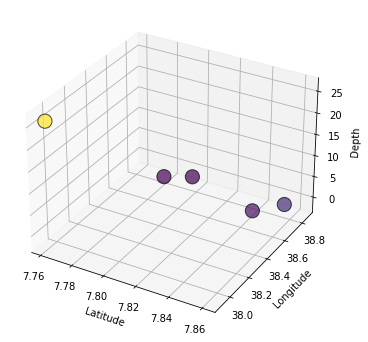

In [83]:
from mpl_toolkits.mplot3d import Axes3D

x = df_test['    Lat ']
y = df_test['    Lon  ']
z = df_test['   Dep  ']

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Depth')
plt.show()

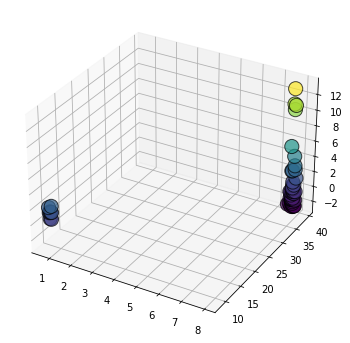

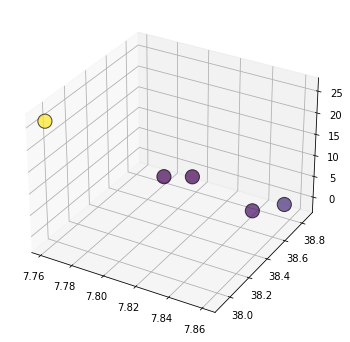

In [89]:
a = df_events["lat"]
b = df_events["lon"]
c = df_events["depth"]

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(a, b, c,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=c)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Depth')

x = df_test['    Lat ']
y = df_test['    Lon  ']
z = df_test['   Dep  ']

fig = plt.figure(figsize=(6, 6))
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Depth')
plt.show()